In [1]:
# STEP 1: SETUP
from google.colab import drive
drive.mount('/content/drive')

! pip install ultralytics -q

import os
os.makedirs("/content/datasets", exist_ok=True)
os.makedirs("/content/drive/MyDrive/Apex_Traffic_Intelligence/models/configs", exist_ok=True)
os.makedirs("/content/drive/MyDrive/Apex_Traffic_Intelligence/models/weights", exist_ok=True)
os.makedirs("/content/drive/MyDrive/Apex_Traffic_Intelligence/reports/charts", exist_ok=True)

import torch
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
print("STEP 1 DONE")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.7 MB/s eta 0:00:00
GPU: CPU
STEP 1 DONE


In [2]:
# STEP 2: DOWNLOAD DATASET
! wget -q --show-progress -P /content/datasets https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-train.zip
!wget -q --show-progress -P /content/datasets https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-val.zip
!wget -q --show-progress -P /content/datasets https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-test-dev.zip

import zipfile, os
for s in ['train', 'val', 'test-dev']:
    z = "/content/datasets/VisDrone2019-DET-" + s + ".zip"
    if os.path. exists(z):
        zipfile.ZipFile(z, 'r').extractall("/content/datasets")
        os.remove(z)
        print(s, "done")

print("STEP 2 DONE")

VisDrone2019-DET-tr 100%[===================>]   1.44G   110MB/s    in 15s     
VisDrone2019-DET-va 100%[===================>]  77.86M   158MB/s    in 0.5s    
VisDrone2019-DET-te 100%[===================>] 296.83M  10.5MB/s    in 6.2s    
train done
val done
test-dev done
STEP 2 DONE


In [ ]:
# STEP 3: CONVERT ANNOTATIONS
import glob, os
from PIL import Image
from tqdm import tqdm

cat_map = {1:0, 2:1, 3:2, 4:3, 5:4, 6:5, 7:6, 8:7, 9:8, 10:9}

for s in ['train', 'val', 'test-dev']:
    img_dir = "/content/datasets/VisDrone2019-DET-" + s + "/images"
    ann_dir = "/content/datasets/VisDrone2019-DET-" + s + "/annotations"
    lbl_dir = "/content/datasets/VisDrone2019-DET-" + s + "/labels"

    if not os.path. exists(ann_dir):
        continue

    os.makedirs(lbl_dir, exist_ok=True)
    images = glob.glob(img_dir + "/*.jpg")
    print(s + ":", len(images), "images")

    for img_path in tqdm(images):
        base = os.path.basename(img_path).replace(".jpg", "")
        ann_path = ann_dir + "/" + base + ". txt"

        if not os.path.exists(ann_path):
            continue

        img = Image.open(img_path)
        W, H = img.size
        img. close()

        lines = []
        with open(ann_path) as f:
            for line in f:
                p = line.strip().split(',')
                if len(p) < 6:
                    continue
                x, y, w, h, cat = float(p[0]), float(p[1]), float(p[2]), float(p[3]), int(p[5])
                if cat not in cat_map or w <= 0 or h <= 0:
                    continue
                xc = max(0, min(1, (x + w/2) / W))
                yc = max(0, min(1, (y + h/2) / H))
                wn = max(0, min(1, w / W))
                hn = max(0, min(1, h / H))
                lines.append(str(cat_map[cat]) + " " + str(round(xc,6)) + " " + str(round(yc,6)) + " " + str(round(wn,6)) + " " + str(round(hn,6)))

        with open(lbl_dir + "/" + base + ".txt", 'w') as f:
            f.write('\n'.join(lines))

print("STEP 3 DONE")

train: 6471 images


100%|██████████| 6471/6471 [00:00<00:00, 171013.25it/s]


val: 548 images


100%|██████████| 548/548 [00:00<00:00, 135603.46it/s]


test-dev: 1610 images


100%|██████████| 1610/1610 [00:00<00:00, 156308.26it/s]

STEP 3 DONE


In [ ]:
# FIX: Robust conversion of VisDrone annotations -> YOLO labels
import os, glob
from PIL import Image

DATA_PATH = "/content/datasets"
splits = ["train", "val", "test-dev"]
cat_map = {1:0,2:1,3:2,4:3,5:4,6:5,7:6,8:7,9:8,10:9}

for s in splits:
    ann_dir = os.path.join(DATA_PATH, f"VisDrone2019-DET-{s}", "annotations")
    img_dir = os.path.join(DATA_PATH, f"VisDrone2019-DET-{s}", "images")
    lbl_dir = os.path.join(DATA_PATH, f"VisDrone2019-DET-{s}", "labels")
    print(f"\n--- {s.upper()} ---")
    if not os.path.exists(ann_dir):
        print("annotations folder NOT FOUND:", ann_dir)
        continue
    ann_files = sorted(glob.glob(os.path.join(ann_dir, "*.txt")))
    print("annotation files found:", len(ann_files))
    if len(ann_files) == 0:
        continue
    os.makedirs(lbl_dir, exist_ok=True)
    converted = 0
    for ann_path in ann_files:
        base = os.path.splitext(os.path.basename(ann_path))[0]
        img_path = os.path.join(img_dir, base + ".jpg")
        # If image missing, try common alternatives (just in case)
        if not os.path.exists(img_path):
            alt = glob.glob(os.path.join(img_dir, base + ".*"))
            img_path = alt[0] if alt else None
        if img_path is None or not os.path.exists(img_path):
            # skip if no matching image
            continue
        try:
            with Image.open(img_path) as im:
                W, H = im.size
        except Exception:
            continue
        out_lines = []
        with open(ann_path, "r") as f:
            for line in f:
                parts = line.strip().split(",")
                if len(parts) < 6:
                    continue
                try:
                    x, y, w, h = float(parts[0]), float(parts[1]), float(parts[2]), float(parts[3])
                    cls = int(parts[5])
                except:
                    continue
                if cls not in cat_map or w <= 0 or h <= 0:
                    continue
                xc = max(0.0, min(1.0, round((x + w/2) / W, 6)))
                yc = max(0.0, min(1.0, round((y + h/2) / H, 6)))
                wn = max(0.0, min(1.0, round(w / W, 6)))
                hn = max(0.0, min(1.0, round(h / H, 6)))
                out_lines.append(f"{cat_map[cls]} {xc} {yc} {wn} {hn}")
        if out_lines:
            with open(os.path.join(lbl_dir, base + ".txt"), "w") as out:
                out.write("\n".join(out_lines))
            converted += 1
    print("labels written:", converted)
    # show a few examples
    sample_labels = sorted(glob.glob(os.path.join(lbl_dir, "*.txt")))[:3]
    print("sample label files:", sample_labels)


--- TRAIN ---
annotation files found: 6471
labels written: 6471
sample label files: ['/content/datasets/VisDrone2019-DET-train/labels/0000002_00005_d_0000014.txt', '/content/datasets/VisDrone2019-DET-train/labels/0000002_00448_d_0000015.txt', '/content/datasets/VisDrone2019-DET-train/labels/0000003_00231_d_0000016.txt']

--- VAL ---
annotation files found: 548
labels written: 548
sample label files: ['/content/datasets/VisDrone2019-DET-val/labels/0000001_02999_d_0000005.txt', '/content/datasets/VisDrone2019-DET-val/labels/0000001_03499_d_0000006.txt', '/content/datasets/VisDrone2019-DET-val/labels/0000001_03999_d_0000007.txt']

--- TEST-DEV ---
annotation files found: 1610
labels written: 1610
sample label files: ['/content/datasets/VisDrone2019-DET-test-dev/labels/0000006_00159_d_0000001.txt', '/content/datasets/VisDrone2019-DET-test-dev/labels/0000006_00611_d_0000002.txt', '/content/datasets/VisDrone2019-DET-test-dev/labels/0000006_01111_d_0000003.txt']


In [ ]:
# STEP 5: VERIFY LABELS & WRITE YAML
import os, glob, textwrap

DATA_PATH = "/content/datasets"
BASE = "/content/drive/MyDrive/Apex_Traffic_Intelligence"
yaml_path = os.path.join(BASE, "models/configs/visdrone.yaml")
classes = ['pedestrian','people','bicycle','car','van','truck','tricycle','awning-tricycle','bus','motor']

total_imgs = total_lbls = 0
for s in ["train","val","test-dev"]:
    imgs = glob.glob(f"{DATA_PATH}/VisDrone2019-DET-{s}/images/*.jpg")
    lbls = glob.glob(f"{DATA_PATH}/VisDrone2019-DET-{s}/labels/*.txt")
    print(f"{s}: {len(imgs)} images, {len(lbls)} labels")
    total_imgs += len(imgs); total_lbls += len(lbls)

print(f"TOTAL: {total_imgs} images, {total_lbls} labels\n")

# show 2 samples (if available)
for s in ["train","val"]:
    imgs = glob.glob(f"{DATA_PATH}/VisDrone2019-DET-{s}/images/*.jpg")[:2]
    lbls = glob.glob(f"{DATA_PATH}/VisDrone2019-DET-{s}/labels/*.txt")[:2]
    print(f"Sample {s} images: {imgs}")
    print(f"Sample {s} labels: {lbls}\n")

if total_lbls == 0:
    print("WARNING: No labels found. Re-run conversion (STEP 3) or check annotation files.")
else:
    yaml_text = textwrap.dedent(f"""\
        path: {DATA_PATH}
        train: VisDrone2019-DET-train/images
        val: VisDrone2019-DET-val/images
        test: VisDrone2019-DET-test-dev/images

        nc: {len(classes)}
        names: {classes}
    """)
    os.makedirs(os.path.dirname(yaml_path), exist_ok=True)
    with open(yaml_path, "w") as f:
        f.write(yaml_text)
    print("YAML saved to:", yaml_path)

train: 6471 images, 6471 labels
val: 548 images, 548 labels
test-dev: 1610 images, 1610 labels
TOTAL: 8629 images, 8629 labels

Sample train images: ['/content/datasets/VisDrone2019-DET-train/images/9999955_00000_d_0000378.jpg', '/content/datasets/VisDrone2019-DET-train/images/9999964_00000_d_0000022.jpg']
Sample train labels: ['/content/datasets/VisDrone2019-DET-train/labels/9999999_00291_d_0000128.txt', '/content/datasets/VisDrone2019-DET-train/labels/9999951_00000_d_0000028.txt']

Sample val images: ['/content/datasets/VisDrone2019-DET-val/images/0000335_00001_d_0000043.jpg', '/content/datasets/VisDrone2019-DET-val/images/0000115_01031_d_0000082.jpg']
Sample val labels: ['/content/datasets/VisDrone2019-DET-val/labels/0000276_04601_d_0000530.txt', '/content/datasets/VisDrone2019-DET-val/labels/0000346_03921_d_0000366.txt']

YAML saved to: /content/drive/MyDrive/Apex_Traffic_Intelligence/models/configs/visdrone.yaml


0 pedestrian: 79337
1 people: 27059
2 bicycle: 10480
3 car: 144866
4 van: 24956
5 truck: 12875
6 tricycle: 4812
7 awning-tricycle: 3246
8 bus: 5926
9 motor: 29647


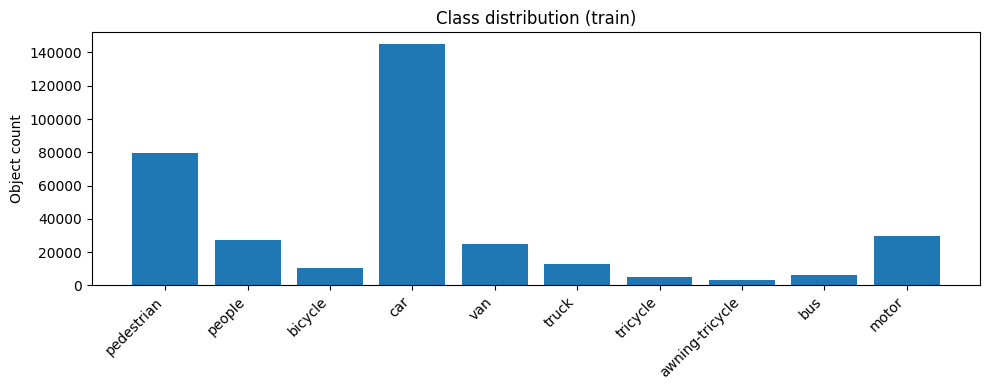

Chart saved to: /content/drive/MyDrive/Apex_Traffic_Intelligence/reports/charts/class_distribution.png


In [ ]:
# STEP 6: CLASS DISTRIBUTION (quick)
import glob, os
import matplotlib.pyplot as plt
from collections import Counter

DATA_PATH = "/content/datasets"
BASE = "/content/drive/MyDrive/Apex_Traffic_Intelligence"
CLS = ['pedestrian','people','bicycle','car','van','truck','tricycle','awning-tricycle','bus','motor']

lbl_files = glob.glob(f"{DATA_PATH}/VisDrone2019-DET-train/labels/*.txt")
if len(lbl_files) == 0:
    print("No label files found in train labels. Re-run STEP 3.")
else:
    counts = Counter()
    for f in lbl_files:
        with open(f) as fh:
            for line in fh:
                parts = line.strip().split()
                if not parts:
                    continue
                cls_id = int(parts[0])
                counts[cls_id] += 1

    # print counts
    for i, name in enumerate(CLS):
        print(f"{i} {name}: {counts.get(i,0)}")

    # plot
    vals = [counts.get(i,0) for i in range(len(CLS))]
    plt.figure(figsize=(10,4))
    plt.bar(CLS, vals, color='tab:blue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Object count")
    plt.title("Class distribution (train)")
    os.makedirs(BASE + "/reports/charts", exist_ok=True)
    out = BASE + "/reports/charts/class_distribution.png"
    plt.tight_layout()
    plt.savefig(out)
    plt.show()
    print("Chart saved to:", out)

In [ ]:
# STEP 7: TRAIN MODEL (single cell)
import os, shutil, torch
from ultralytics import YOLO

BASE = "/content/drive/MyDrive/Apex_Traffic_Intelligence"
yaml_path = os.path.join(BASE, "models/configs/visdrone.yaml")
project_dir = os.path.join(BASE, "models/finetuned")
run_name = "apex_traffic_v1"
train_dir = os.path.join(project_dir, run_name)
weights_out = os.path.join(BASE, "models/weights", "apex_traffic_best.pt")

# quick checks
if not os.path.exists(yaml_path):
    raise SystemExit(f"YAML not found: {yaml_path}. Run STEP 5 first.")

device = 0 if torch.cuda.is_available() else 'cpu'
print("Device:", "GPU" if device == 0 else "CPU")
print("Training will save to:", train_dir)

# remove old run to avoid conflicts
if os.path.exists(train_dir):
    print("Removing previous training folder:", train_dir)
    shutil.rmtree(train_dir)

# load model (will download if needed)
model = YOLO("yolov8m.pt")  # change to yolov8n.pt for faster/cheaper training

# train
print("Starting training... (this may take 30-45 minutes on T4)")
try:
    model.train(
        data=yaml_path,
        epochs=20,
        imgsz=640,
        batch=16,
        device=device,
        project=project_dir,
        name=run_name,
        patience=10,
        save=True,
        plots=True
    )
except Exception as e:
    print("TRAINING ERROR:", e)
    raise

# copy best weights to final location if present
best = os.path.join(train_dir, "weights", "best.pt")
if os.path.exists(best):
    os.makedirs(os.path.dirname(weights_out), exist_ok=True)
    shutil.copy(best, weights_out)
    print("Best weights saved to:", weights_out)
else:
    print("Best weights not found in:", best)

print("STEP 7 DONE — training finished (or stopped).")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: GPU
Training will save to: /content/drive/MyDrive/Apex_Traffic_Intelligence/models/finetuned/apex_traffic_v1
Removing previous training folder: /content/drive/MyDrive/Apex_Traffic_Intelligence/models/finetuned/apex_traffic_v1
Starting training... (this may take 30-45 minutes on T4)
Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Apex_Traffic_Intell

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/1 /content/datasets/VisDrone2019-DET-test-dev/images/9999952_00000_d_0000015.jpg: 384x640 2 pedestrians, 8 cars, 2 trucks, 1 bus, 1563.6ms
Speed: 18.6ms preprocess, 1563.6ms inference, 40.4ms postprocess per image at shape (1, 3, 384, 640)
--- DETECTED COUNTS FOR IMAGE: 9999952_00000_d_0000015.jpg ---
truck: 2
car: 8
pedestrian: 2
bus: 1


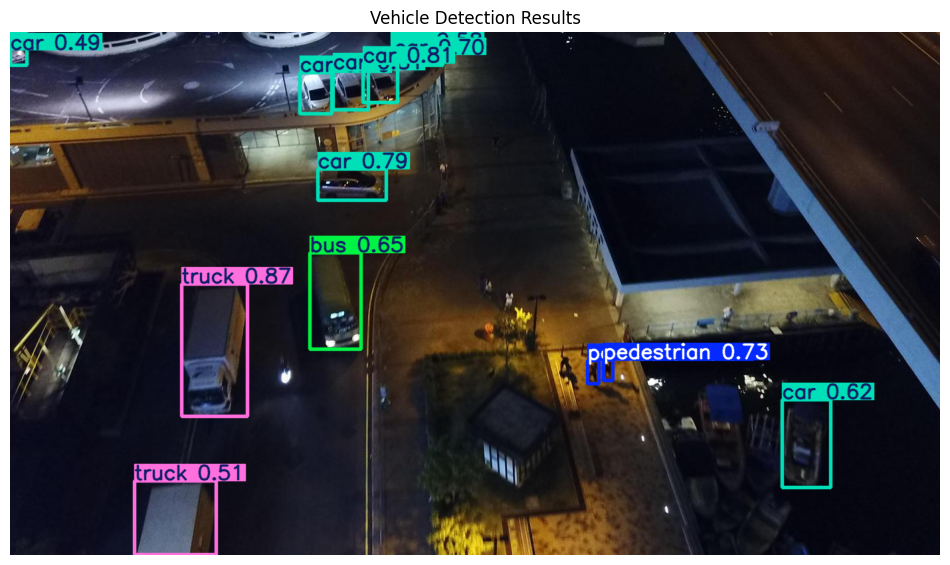

In [3]:
# STEP 8: INFERENCE & COUNTING
from ultralytics import YOLO
from collections import Counter
import cv2
import matplotlib.pyplot as plt
import glob

# Load your trained model
model_path = "/content/drive/MyDrive/Apex_Traffic_Intelligence/models/weights/apex_traffic_best.pt"
model = YOLO(model_path)

# Pick a random test image
test_images = glob.glob("/content/datasets/VisDrone2019-DET-test-dev/images/*.jpg")
img_path = test_images[50] # Select arbitrary image

# Run detection
results = model.predict(img_path, conf=0.4) # Confidence threshold 0.4
result = results[0]

# Count the classes detected
class_counts = Counter()
detected_classes = []

for box in result.boxes:
    cls_id = int(box.cls[0])
    class_name = result.names[cls_id]
    class_counts[class_name] += 1
    detected_classes.append(class_name)

print(f"--- DETECTED COUNTS FOR IMAGE: {os.path.basename(img_path)} ---")
for cls_name, count in class_counts.items():
    print(f"{cls_name}: {count}")

# Show the image with bounding boxes
plt.figure(figsize=(12, 8))
plt.imshow(result.plot()[:, :, ::-1]) # Convert BGR to RGB for matplotlib
plt.axis('off')
plt.title("Vehicle Detection Results")
plt.show()

Report chart saved to: /content/drive/MyDrive/Apex_Traffic_Intelligence/reports/charts/traffic_volume_report.png


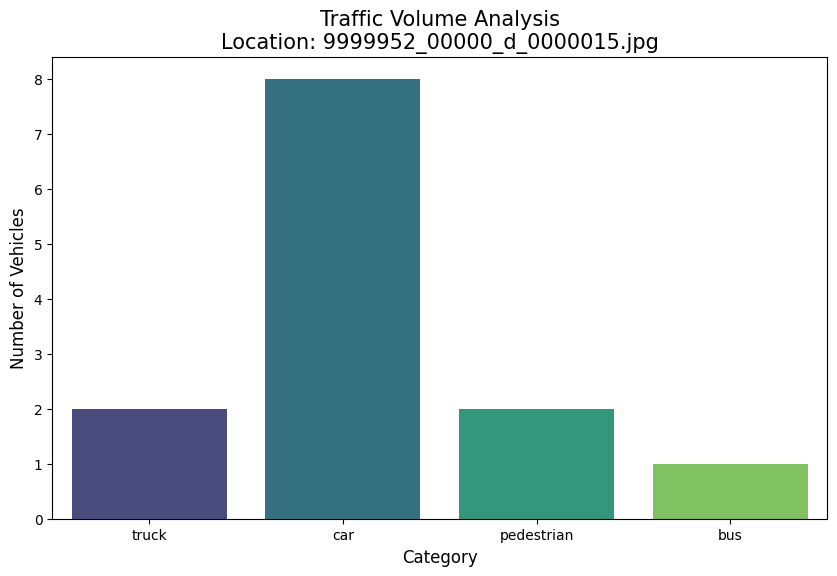

In [4]:
# STEP 9: GENERATE TRAFFIC REPORT CHART
import pandas as pd
import seaborn as sns

# Convert counts to a DataFrame for reporting
df_report = pd.DataFrame(list(class_counts.items()), columns=['Vehicle Type', 'Count'])

# Create a bar chart for the report
plt.figure(figsize=(10, 6))
sns.barplot(data=df_report, x='Vehicle Type', y='Count', hue='Vehicle Type', palette='viridis', legend=False)
plt.title(f'Traffic Volume Analysis\nLocation: {os.path.basename(img_path)}', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Vehicles', fontsize=12)

# Save the report chart
save_path = "/content/drive/MyDrive/Apex_Traffic_Intelligence/reports/charts/traffic_volume_report.png"
plt.savefig(save_path)
print(f"Report chart saved to: {save_path}")
plt.show()